**Step 0 - install and import dependencies**

In [ ]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [2]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [3]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Voice of customer/Wongnai Reviews - Small.csv")

In [7]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [8]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [318]:
#reduce array dimensions using umap (you can chagne n_components)

#reducer = umap.UMAP(random_state=42,n_components=50)
reducer = umap.UMAP(random_state=42,n_components=200)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

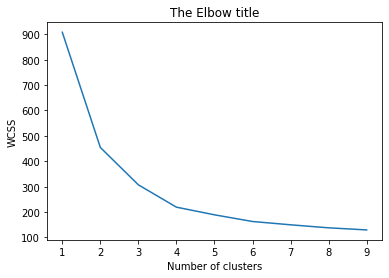

In [319]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [357]:
#run kmeans with no. of clusters you see fit the most

k = 3

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [358]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [359]:
df_kmeans

,KMeans ID,texts
0,0,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
1,1,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
2,2,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...


In [360]:
for i in range(len(df_kmeans)):
  print(df_kmeans.iloc[i].texts+'\n')

2      กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3      วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4      ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...
6      สวัสดีเพื่อนๆสมาชิกนักรีวิวร้านอาหารชาว Wongna...
9      ร้านส้มตำเจ๊พิมอยู่ถนนเลี่ยงตลาดหนองมน\nเป็นร้...
14     ตอนเย็นๆหน่อยถ้าลงจากรถไฟฟ้าราชเทวีแล้วเดินย้อ...
17     แมทช์นี้ที่หัวหิน... ระหว่างที่ยังตกลงว่าทานกล...
22     ขอไปกินกับเค้าบ้างเหอะ แหม อยู่ใกล้บ้านตั้งขนา...
25     มีคนแนะนำมาว่าต้องร้านนี้ \nเลยขอลองสักหน่อย ไ...
35     ร้านนี้ ใครๆก็รู้จักว่าเป็นร้านกาแฟ แต่อาหารขอ...
36     ร้านตกแต่งน่ารักมาก สไตล์นั่งอยู่ในบ้านก็จะมีข...
38     ร้านนี้เป็นของดาราตลกชื่อดังค่ะ คุณหม่ำนั่นเอง...
41     ร้านอาหารเรื่อนปั้นหยา ที่จอดรถกว้างขวางสะดวกส...
46     ร้านอาหารไทยฟิวชั่น อร่อย สะอาด แต่ราคาสูงไปนิ...
49     สาระพัดยำ แบบแซ่บๆ ราคาไม่แพง\n\nร้านยำแซ่บ สา...
56     เป็นร้านที่ได้ผักเยอะมากกกกกกกกกกก อร่อยคุ้มรา...
60     ร้านก๋วยเตี๋ยว 22 เป็นร้านเก่าแก่ ครองใจคนชลบุ...
65     ใครรักข้าวห่อไข่ มาจานนี

In [361]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [362]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [363]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [364]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [365]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [366]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [367]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน','ทาน','กิน','เมนู','สั่ง','อาหาร','ราคา','(',')',',','ผม','ดิชั้น','[','ดิ','ชั้น','โมง','-','.']
screening_words = stopwords + removed_words

new_words = {"สตารบัก"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [368]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [369]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คว...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 14), (อร่อย, 11), (กก, 10), (บ้าน..."
1,1,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, Macchiato, เป็นประจำ, นึง, เด, Artof...","[(ร้านกาแฟ, 25), (กาแฟ, 23), (ชอบ, 11), (คาเฟ่..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (รีวิว, 5),..."


In [370]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านอาหาร', 14), ('อร่อย', 11), ('กก', 10), ('บ้าน', 6), ('รีวิว', 6), ('ส้มตำ', 6), ('ซอย', 6), ('สาขา', 6), ('เพื่อน', 5), ('ไทย', 5)]

Cluster ID : 1

Most common words include : [('ร้านกาแฟ', 25), ('กาแฟ', 23), ('ชอบ', 11), ('คาเฟ่', 6), ('น', 6), ('แวะ', 6), ('ดี', 6), ('รี่', 5), ('อร่อย', 5), ('กา', 5)]

Cluster ID : 2

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('รีวิว', 5), ('เครื่องดื่ม', 4), ('ร้า', 3), ('น้ำ', 3), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3)]



**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [371]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=k, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [372]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [373]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [374]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 509), ('รสชาติ', 414), ('ดี', 348), ('กาแฟ', 315), ('ชา', 264), ('บาท', 242), ('ชอบ', 232), ("','", 219), ('คน', 217), ('หวาน', 206)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ซื้อ', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3)]

Cluster ID : 2

Most common words include : [('ปัง', 4), ('ภูเขาไฟ', 3), ('ๆๆๆ', 2), ("['", 1), ('อ่', 1), ('กา', 1), ('ศ', 1), ('ร้อน', 1), ('เข้ากัน', 1), ('ฝุดๆ', 1)]



**Step 4 - result discussion**

ใช้ model K-Mean ธรรมดาให้ชุดคำที่ดูเป็นหมวดหมู่มากกว่า Agglomorative Clustering

Cluster ID : 0 --> ร้านอาหารไทย - ส้มตำ

Most common words include : [('ร้านอาหาร', 14), ('อร่อย', 11), ('กก', 10), ('บ้าน', 6), ('รีวิว', 6), ('ส้มตำ', 6), ('ซอย', 6), ('สาขา', 6), ('เพื่อน', 5), ('ไทย', 5)]

Cluster ID : 1 --> คาเฟ่ / ร้านกาแฟ

Most common words include : [('ร้านกาแฟ', 25), ('กาแฟ', 23), ('ชอบ', 11), ('คาเฟ่', 6), ('น', 6), ('แวะ', 6), ('ดี', 6), ('รี่', 5), ('อร่อย', 5), ('กา', 5)]

Cluster ID : 2 --> ชานมไข่มุก

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('รีวิว', 5), ('เครื่องดื่ม', 4), ('ร้า', 3), ('น้ำ', 3), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3)]